In [1]:
import tweepy 
import configparser
import requests     # For saving access tokens and for file management when creating and adding to the dataset
import os           # For dealing with json responses we receive from the API
import json         # For displaying the data after
import pandas as pd # For saving the response data in CSV format
import csv          # For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata  #To add wait time between requests
import time
import sqlite3
import re
import twitter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance,PartOfSpeech
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
from sklearn.model_selection import RandomizedSearchCV
from flair.embeddings import TransformerDocumentEmbeddings
import numpy as np
from twitter import *
from functools import partial
from collections import Counter
import nltk
import string
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('../database/twitter_data.db')

In [3]:
# Retrieve the data from the SQLite database
query = "SELECT * FROM tweets"
tweets_df = pd.read_sql_query(query, conn, parse_dates=['created_at'])
tweets_df.to_pickle('../data/tweets_df.pkl')
print(tweets_df.dtypes)


# Retrieve the data from the SQLite database
query = "SELECT * FROM users"
users_df = pd.read_sql_query(query, conn, parse_dates=['author_created'])
users_df.to_pickle('../data/users_df.pkl')
print(users_df.dtypes)

tweet_id                  int64
author_id                 int64
created_at       datetime64[ns]
text                     object
tweet_metrics            object
entities                 object
context                  object
place_id                 object
dtype: object
author_id                        int64
username                        object
verified                        object
bio                             object
author_created     datetime64[ns, UTC]
author_location                 object
followers_count                  int64
following_count                  int64
tweet_count                      int64
entities                        object
dtype: object


In [14]:
def aggregate_data(df):
    """
    Aggregate data based on domain ID from the provided tweets DataFrame.

    Args:
        tweets_df (pd.DataFrame): DataFrame containing tweet data.

    Returns:
        pd.DataFrame: DataFrame with aggregated data based on domain ID.
    """
    subset_df = df[['tweet_id', 'author_id', 'tweet_metrics', 'context', 'entities']]

    subset_context_items = []
    for index, row in subset_df.iterrows():
        context_list = json.loads(row['context'])
        tweet_id     = row['tweet_id']
        author_id    = row['author_id']
        for item in context_list:
            domain_id   = item['domain']['id']
            domain_name = item['domain']['name']
            entity_id   = item['entity']['id']
            entity_name = item['entity']['name']
            data = {'tweet_id': tweet_id, 'author_id': author_id, 'domain_id':domain_id, 'domain_name': domain_name, 'entity_id':entity_id, 'entity_name': entity_name}
            subset_context_items.append(data)

    subset_context_item_df = pd.DataFrame(subset_context_items)
    return subset_context_item_df

subset_context_item_df = aggregate_data(df=tweets_df)

In [15]:
def calculate_top_counts(data_frame, group_by_cols, aggregate_col, top_n):
    """
    Calculate the top counts based on the given DataFrame, group by columns, aggregate column, and number of top counts to retrieve.
    
    Parameters:
        data_frame (pandas.DataFrame): DataFrame containing the data to perform calculations on.
        group_by_cols (list): List of columns to group by.
        aggregate_col (str): Column to perform aggregation on.
        top_n (int): Number of top counts to retrieve.
        
    Returns:
        pandas.DataFrame: Top counts, sorted in descending order.
    """
    subset_agg = data_frame.groupby(by=group_by_cols).agg({aggregate_col: pd.Series.nunique}).reset_index().sort_values(by=aggregate_col, ascending=False)
    top_counts = subset_agg.head(top_n)
    
    return top_counts

top_20_domain_counts = calculate_top_counts(subset_context_item_df, ["domain_name"], "tweet_id", 20)
top_50_entity_counts = calculate_top_counts(subset_context_item_df, ["entity_name"], "tweet_id", 50)

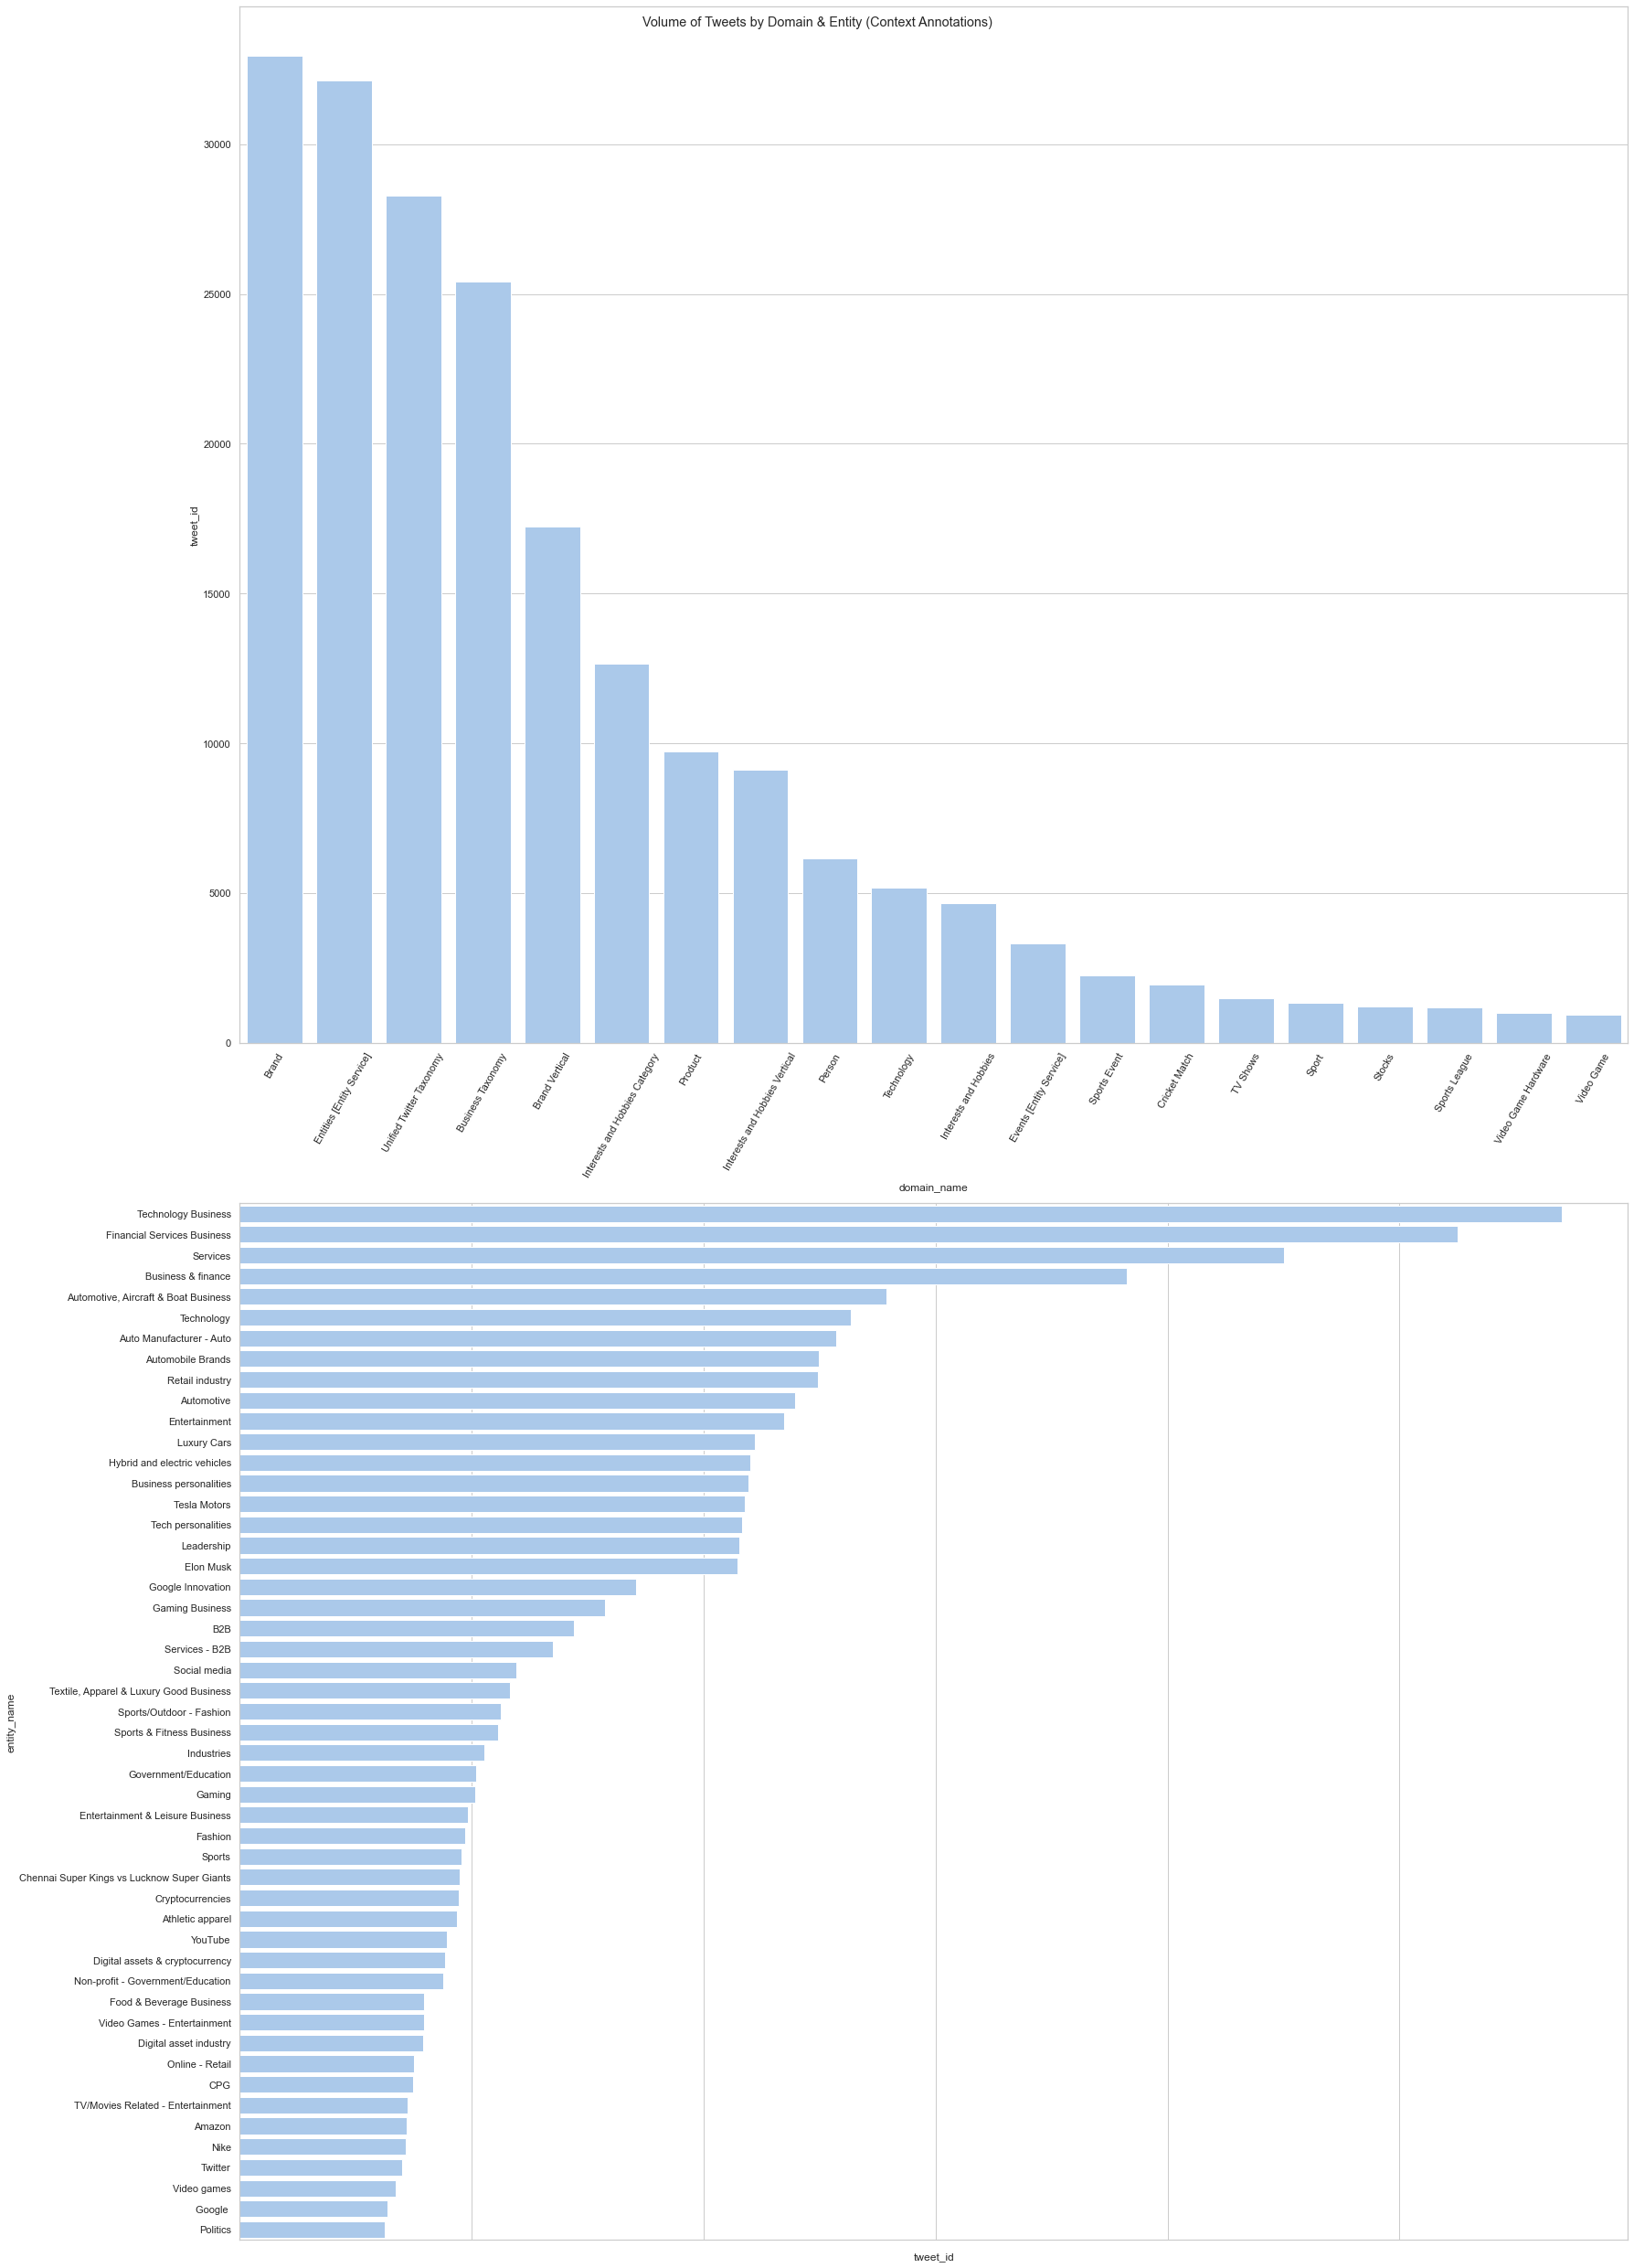

In [17]:
fig, axs = plt.subplots(2, figsize = (25, 35))
fig.suptitle('Volume of Tweets by Domain & Entity (Context Annotations)')

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(ax=axs[0], x=top_20_domain_counts['domain_name'], y=top_20_domain_counts['tweet_id'], color="b")
sns.barplot(ax=axs[1], x=top_50_entity_counts['tweet_id'], y=top_50_entity_counts['entity_name'], color="b", orient='h')


# Rotate the x-axis labels
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=60)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)


plt.tight_layout()  # Adjust spacing to avoid label overlap

plt.show()

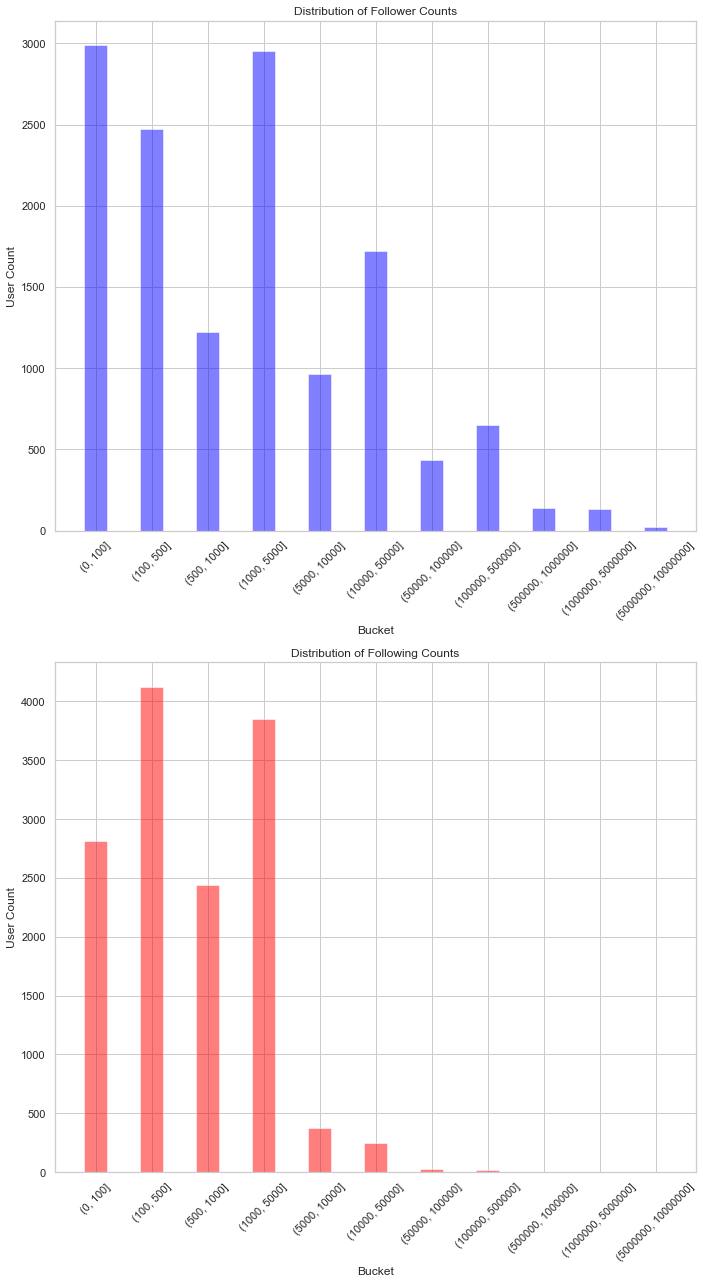

In [18]:
# Define the buckets for follower and following counts
buckets = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]

# Count the number of users in each bucket
follower_counts = pd.cut(users_df['followers_count'], buckets).value_counts().sort_index()
following_counts = pd.cut(users_df['following_count'], buckets).value_counts().sort_index()
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 18))

# Plot follower count distribution
axs[0].bar(range(len(follower_counts)), follower_counts, width=0.4, align='center', alpha=0.5, color='blue')
axs[0].set_xlabel('Bucket')
axs[0].set_ylabel('User Count')
axs[0].set_title('Distribution of Follower Counts')
axs[0].set_xticks(range(len(follower_counts)))
axs[0].set_xticklabels(follower_counts.index, rotation=45)

# Plot following count distribution
axs[1].bar(range(len(following_counts)), following_counts, width=0.4, align='center', alpha=0.5, color='red')
axs[1].set_xlabel('Bucket')
axs[1].set_ylabel('User Count')
axs[1].set_title('Distribution of Following Counts')
axs[1].set_xticks(range(len(following_counts)))
axs[1].set_xticklabels(following_counts.index, rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

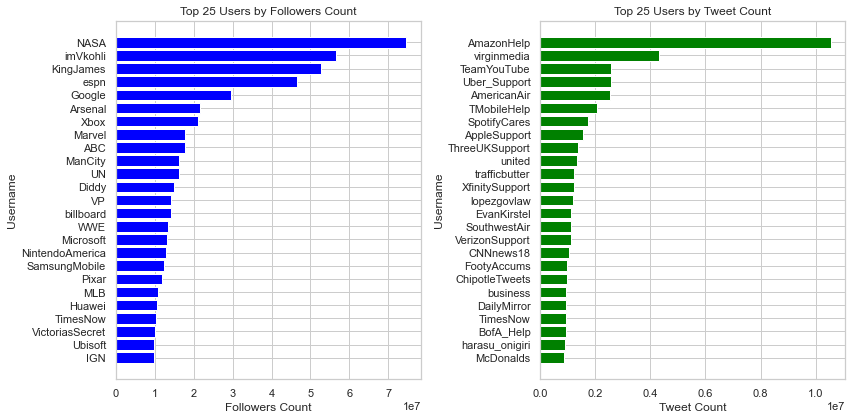

In [19]:
# Sort all users based on followers count in descending order
top_followed_users = users_df.sort_values('followers_count', ascending=False).head(25)

# Sort all users based on tweet count in descending order
top_tweet_users = users_df.sort_values('tweet_count', ascending=False).head(25)

# Create a figure with a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the top followed users
axs[0].barh(top_followed_users['username'], top_followed_users['followers_count'], color='blue')
axs[0].set_xlabel('Followers Count')
axs[0].set_ylabel('Username')
axs[0].set_title('Top 25 Users by Followers Count')
axs[0].invert_yaxis()

# Plot the top tweet users
axs[1].barh(top_tweet_users['username'], top_tweet_users['tweet_count'], color='green')
axs[1].set_xlabel('Tweet Count')
axs[1].set_ylabel('Username')
axs[1].set_title('Top 25 Users by Tweet Count')
axs[1].invert_yaxis()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Data Pre-Processing

The following code will remove emoticons, hyperlinks, whitepsaces such as new lines and indentations.
It will also tokenize text into words, remove slang words, and visualize the text pre-processed data to show patterns

In [20]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [21]:
def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


In [22]:
nltk.download('stopwords')

""" Tokenizes a text to its words, removes and replaces some of them """    
finalTokens = [] # all tokens
stoplist = stopwords.words('english')
my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
allowedWordTypes = ["J","R","V","N"] #  J is Adject, R is Adverb, V is Verb, N is Noun. These are used for POS Tagging

# Create a DataFrame to store the preprocessed text and tweet ID
preprocessed_data = pd.DataFrame(columns=['tweet_id', 'text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def tokenize(text, wordCountBefore, tweet_id):
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = []  # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)  # Technique 7: remove punctuation

    tokens = nltk.word_tokenize(text)

    tagged = nltk.pos_tag(tokens)  # Technique 13: part of speech tagging
    for w in tagged:
        if w[1][0] in allowedWordTypes and w[0] not in stoplist:
            onlyOneSentenceTokens.append(w[0])
            finalTokens.append(w[0])

    onlyOneSentence = " ".join(onlyOneSentenceTokens)

    # Store the preprocessed text and tweet ID in the DataFrame
    preprocessed_data.loc[len(preprocessed_data)] = [tweet_id, onlyOneSentence]

    return finalTokens

In [24]:
from time import time
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Retrieve all tweets from the database
query = "SELECT DISTINCT * FROM tweets"
df_tweets = pd.read_sql_query(query, conn)
#Tweet_id is column 0, text is column 3


t0 = time()
totalSentences = 0
totalEmoticons = 0
totalSlangs = 0
totalSlangsFound = []
totalElongated = 0
totalMultiExclamationMarks = 0
totalMultiQuestionMarks = 0
totalMultiStopMarks = 0
totalAllCaps = 0

# Iterate over each row in df_tweets
for index, row in df_tweets.iterrows():
    totalSentences += 1
    feat = []

    tweet_id = row['tweet_id']
    text     = removeUnicode(row['text'])  # Technique 0
    text     = replaceURL(row['text'])

    wordCountBefore = len(re.findall(r'\w+', text))  # word count of one sentence before preprocess

    emoticons = countEmoticons(text)  # how many emoticons in this sentence
    totalEmoticons += emoticons

    text = removeEmoticons(text)  # removes emoticons from text
    tokens = tokenize(text, wordCountBefore, tweet_id)  

    # print("Processed tweet:", tweet_id)  # Print the tweet ID after processing

# View the resulting preprocessed data
print(preprocessed_data.head())
    
print("Total sentences: ",                          totalSentences,"\n")
print("Total Words before preprocess: ",            len(re.findall(r'\w+', ' '.join(df_tweets['text']))))
print("Total Distinct Tokens before preprocess: ",  len(set(re.findall(r'\w+', ' '.join(df_tweets['text'])))))
print("Average word/sentence before preprocess: ",  len(re.findall(r'\w+', ' '.join(df_tweets['text']))) / totalSentences, "\n")
print("Total Words after preprocess: ",             len(tokens))
print("Total Distinct Tokens after preprocess: ",   len(set(tokens)))
print("Average word/sentence after preprocess: ",   len(tokens)/totalSentences,"\n")


print("Total run time: ",                           time() - t0," seconds\n")

print("Total emoticons: ",                          totalEmoticons,"\n")
print("Total slangs: ",                             totalSlangs,"\n")
# commonSlangs = nltk.FreqDist(totalSlangsFound)
# for (word, count) in commonSlangs.most_common(20): # most common slangs across all texts
#     print(word,"\t",count)
# commonSlangs.plot(20, cumulative=False) # plot most common slangs

print("Total elongated words: ",                    totalElongated,"\n")
print("Total multi exclamation marks: ",            totalMultiExclamationMarks)
print("Total multi question marks: ",               totalMultiQuestionMarks)
print("Total multi stop marks: ",                   totalMultiStopMarks,"\n")
print("Total all capitalized words: ",              totalAllCaps,"\n")

#print(tokens)
# commonWords = nltk.FreqDist(tokens)
# print("Most common words ")
# print("Word\tCount")
# for (word, count) in commonWords.most_common(100): # most common words across all texts
#     print(word,"\t",count)

# Create a larger plot with adjusted dimensions
# plt.figure(figsize=(20, 8))  # Adjust the width and height as needed
# commonWords.plot(100, cumulative=False) # plot most common words


bgm = nltk.collocations.BigramAssocMeasures()
tgm = nltk.collocations.TrigramAssocMeasures()
bgm_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
tgm_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bgm_finder.apply_freq_filter(5) # bigrams that occur at least 5 times
print("Most common collocations (bigrams)")
print(bgm_finder.nbest(bgm.pmi, 20)) # top 50 bigram collocations
tgm_finder.apply_freq_filter(5) # trigrams that occur at least 5 times
print("Most common collocations (trigrams)")
print(tgm_finder.nbest(tgm.pmi, 20)) # top 20 trigrams collocations

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


              tweet_id                                               text
0  1658150278699565056  dont anything share countries time meantime us...
1  1658150503149187076  HPE NVIDIA FlywheelSoftwa1 developed Biomedica...
2  1658150654756397056  FortiXDR cloud native crossproduct detection r...
3  1658150765599371276  DYK NASAs Perseverance Mars rover recently dis...
4  1658151031182700552  Wish learn SciLifeLabDC services tools events ...
Total sentences:  36370 

Total Words before preprocess:  1263128
Total Distinct Tokens before preprocess:  110186
Average word/sentence before preprocess:  34.72994226010448 

Total Words after preprocess:  653611
Total Distinct Tokens after preprocess:  77541
Average word/sentence after preprocess:  17.9711575474292 

Total run time:  290.54907035827637  seconds

Total emoticons:  14990 

Total slangs:  0 

Total elongated words:  0 

Total multi exclamation marks:  0
Total multi question marks:  0
Total multi stop marks:  0 

Total all capitalized

In [25]:
# Merge the preprocessed_data DataFrame with df_tweets based on tweet_id
df_tweets_preprocessed = df_tweets.merge(preprocessed_data, on='tweet_id', how='left', suffixes=('_original', '_preprocessed'))

# Deduplicate the merged DataFrame based on the 'tweet_id' column
df_tweets_preprocessed = df_tweets_preprocessed.drop_duplicates(subset=['tweet_id', 'text_preprocessed'])

In [27]:
df_tweets_preprocessed.to_pickle('../data/df_tweets_preprocessed.pkl')